In [1]:
!pip install stumpy

In [2]:
!pip install https://files.pythonhosted.org/packages/83/c4/9e475caae75829fcb2990d740a8364662b134b4b7cdf2e0b036e0f69d96d/seglearn-1.0.9-py3-none-any.whl

     |████████████████████████████████| 11.3MB 5.1MB/s 


In [3]:
!pip install pyts

     |████████████████████████████████| 2.5MB 5.1MB/s 


In [4]:
import stumpy

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

import gc; gc.enable()

/kaggle/input/ashrae-energy-prediction/building_metadata.csv
/kaggle/input/ashrae-energy-prediction/weather_train.csv
/kaggle/input/ashrae-energy-prediction/sample_submission.csv
/kaggle/input/ashrae-energy-prediction/weather_test.csv
/kaggle/input/ashrae-energy-prediction/test.csv
/kaggle/input/ashrae-energy-prediction/train.csv


In [5]:
PATH = '/kaggle/input/ashrae-energy-prediction/train.csv'
df = pd.read_csv(PATH)
df.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0
1,1,0,2016-01-01 00:00:00,0.0
2,2,0,2016-01-01 00:00:00,0.0
3,3,0,2016-01-01 00:00:00,0.0
4,4,0,2016-01-01 00:00:00,0.0


In [6]:
PATH = '/kaggle/input/ashrae-energy-prediction/sample_submission.csv'
sub = pd.read_csv(PATH)
sub.head()

,row_id,meter_reading
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [7]:
PATH = '/kaggle/input/ashrae-energy-prediction/test.csv'
test = pd.read_csv(PATH)
test.head()

,row_id,building_id,meter,timestamp
0,0,0,0,2017-01-01 00:00:00
1,1,1,0,2017-01-01 00:00:00
2,2,2,0,2017-01-01 00:00:00
3,3,3,0,2017-01-01 00:00:00
4,4,4,0,2017-01-01 00:00:00


In [8]:
del sub; del test; gc.collect();

In [9]:

## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df




In [10]:
# Let's look at a single example for starters...

df = df[df.building_id == 0]
df = reduce_mem_usage(df)
gc.collect();
df.head()

Mem. usage decreased to  0.17 Mb (50.0% reduction)


,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0
2301,0,0,2016-01-01 01:00:00,0.0
4594,0,0,2016-01-01 02:00:00,0.0
6893,0,0,2016-01-01 03:00:00,0.0
9189,0,0,2016-01-01 04:00:00,0.0


In [11]:
df[['meter', 'meter_reading']].groupby('meter').mean()

,meter_reading
meter,
0,146.5


There's only one meter for this building

In [12]:
N = len(df)
df['t'] = range(N)

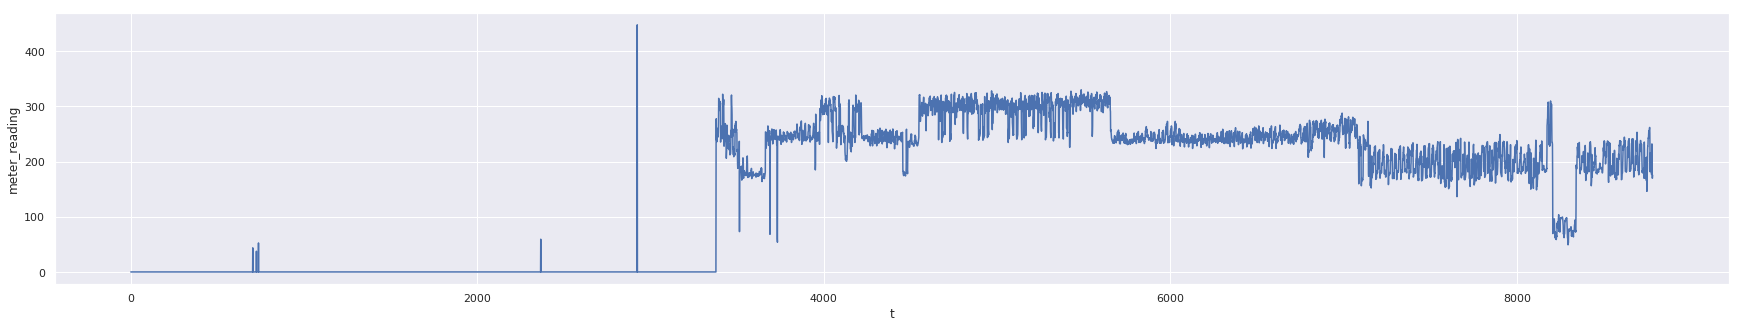

In [13]:
plt.figure(figsize=(30,5))
sns.lineplot(x='t', y='meter_reading', data=df)
plt.show()

In [14]:
# Hmm... it looks like we have data quality issues for the first part of the meter readings (in this case).

In [15]:
PATH = '/kaggle/input/ashrae-energy-prediction/building_metadata.csv'
meta = pd.read_csv(PATH)
meta.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


In [16]:
PATH = '/kaggle/input/ashrae-energy-prediction/weather_train.csv'
weather = pd.read_csv(PATH)
weather.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6


In [17]:
# The air temp is probably important... let's keep that and discard the rest...

In [18]:
del meta;
weather = weather[weather.site_id == 0]
gc.collect();
df = df.merge(weather[['timestamp', 'air_temperature']], on='timestamp', how='left')
df.head(3).append(df.tail(3))

,building_id,meter,timestamp,meter_reading,t,air_temperature
0,0,0,2016-01-01 00:00:00,0.000,0,25.0
1,0,0,2016-01-01 01:00:00,0.000,1,24.4
2,0,0,2016-01-01 02:00:00,0.000,2,22.8
8781,0,0,2016-12-31 21:00:00,170.000,8781,23.3
8782,0,0,2016-12-31 22:00:00,170.000,8782,22.8
8783,0,0,2016-12-31 23:00:00,175.375,8783,20.6


In [19]:
df.isna().any()

building_id        False
meter              False
timestamp          False
meter_reading      False
t                  False
air_temperature     True
dtype: bool

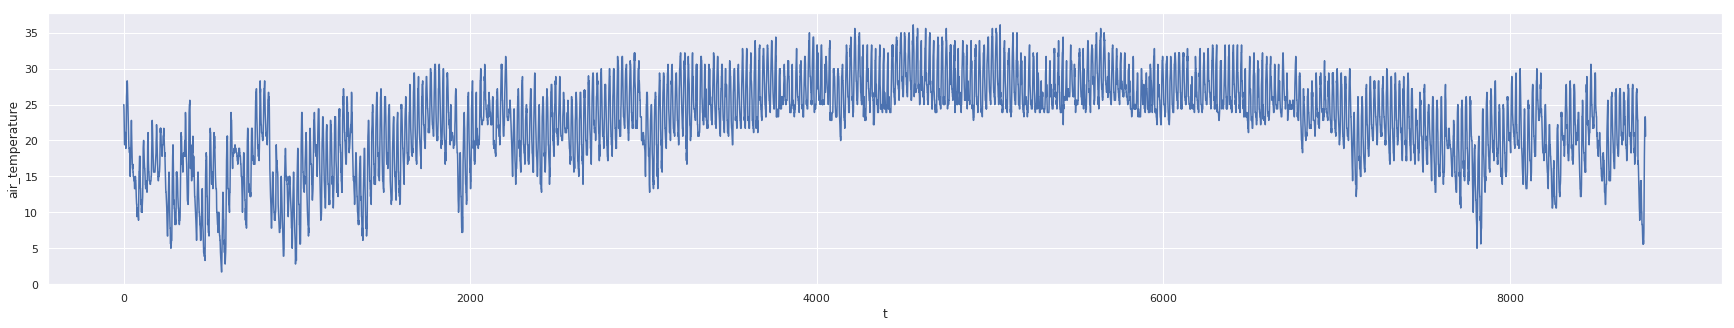

In [20]:
plt.figure(figsize=(30,5))
sns.lineplot(x='t', y='air_temperature', data=df)
plt.show()

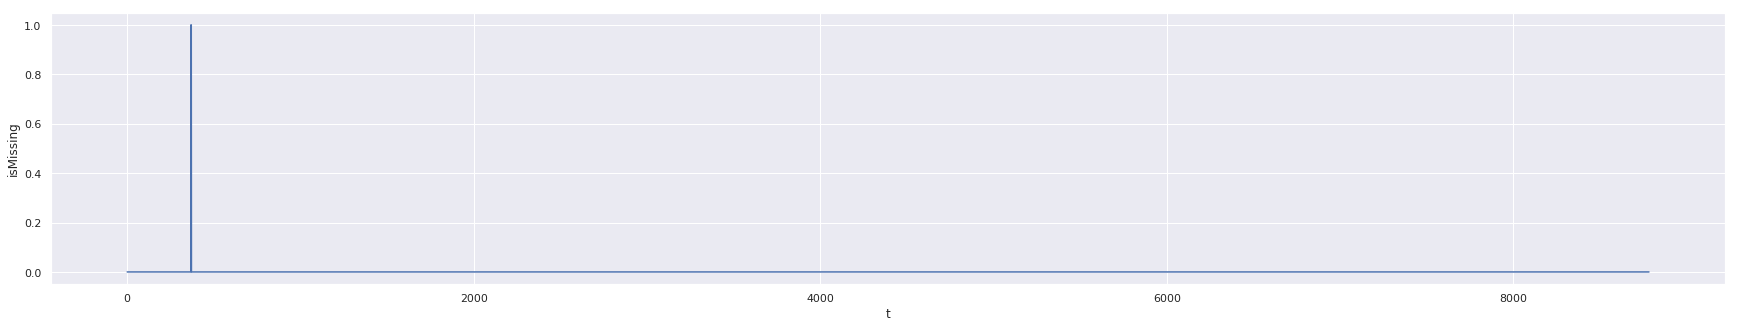

In [21]:
df['isMissing'] = (df.air_temperature.isna()).astype(np.uint8)
df['air_temperature'] = df.air_temperature.interpolate()

plt.figure(figsize=(30,5))
sns.lineplot(x='t', y='isMissing', data=df)
plt.show()

In [22]:
# We don't have a lot of missing data... so it shouldn't be a big deal...

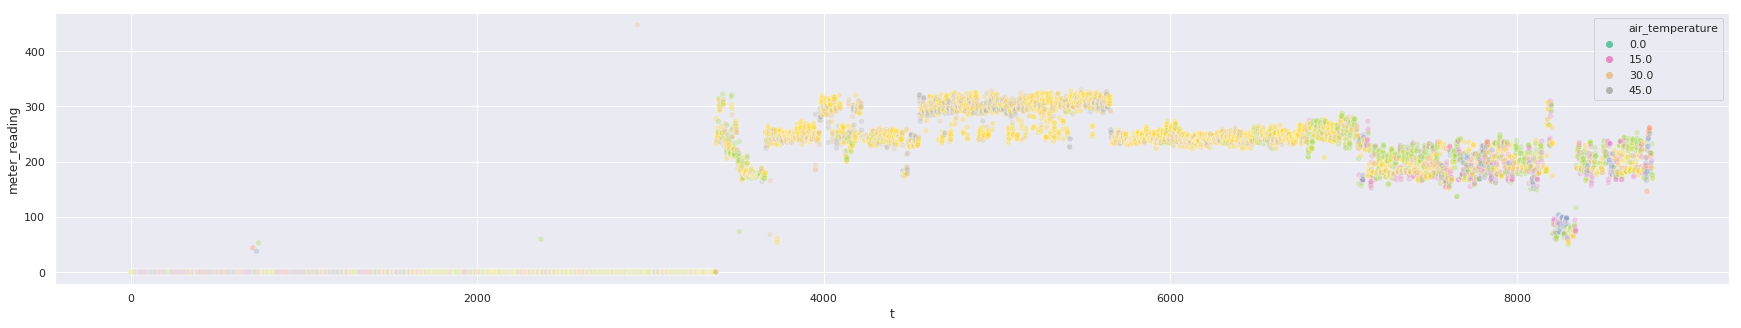

In [23]:
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)

plt.figure(figsize=(30,5))
sns.scatterplot(x='t', y='meter_reading', data=df, hue='air_temperature', palette='Set2', alpha=0.3)
plt.show()

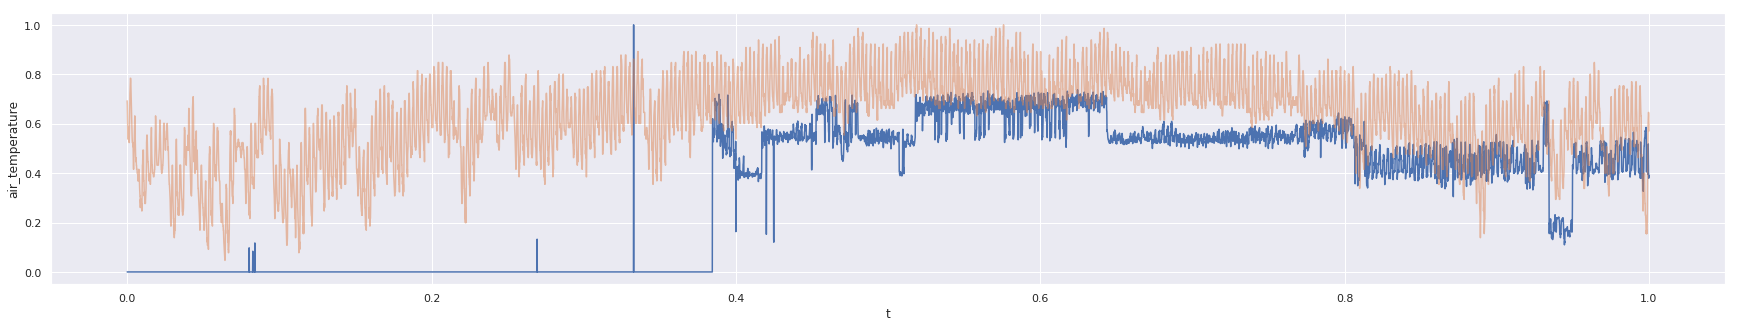

In [24]:
data = df[['t', 'meter_reading', 'air_temperature']]
data /= data.max()

plt.figure(figsize=(30,5))
sns.lineplot(x='t', y='meter_reading', data=data)
sns.lineplot(x='t', y='air_temperature', data=data, alpha=0.5)
plt.show()

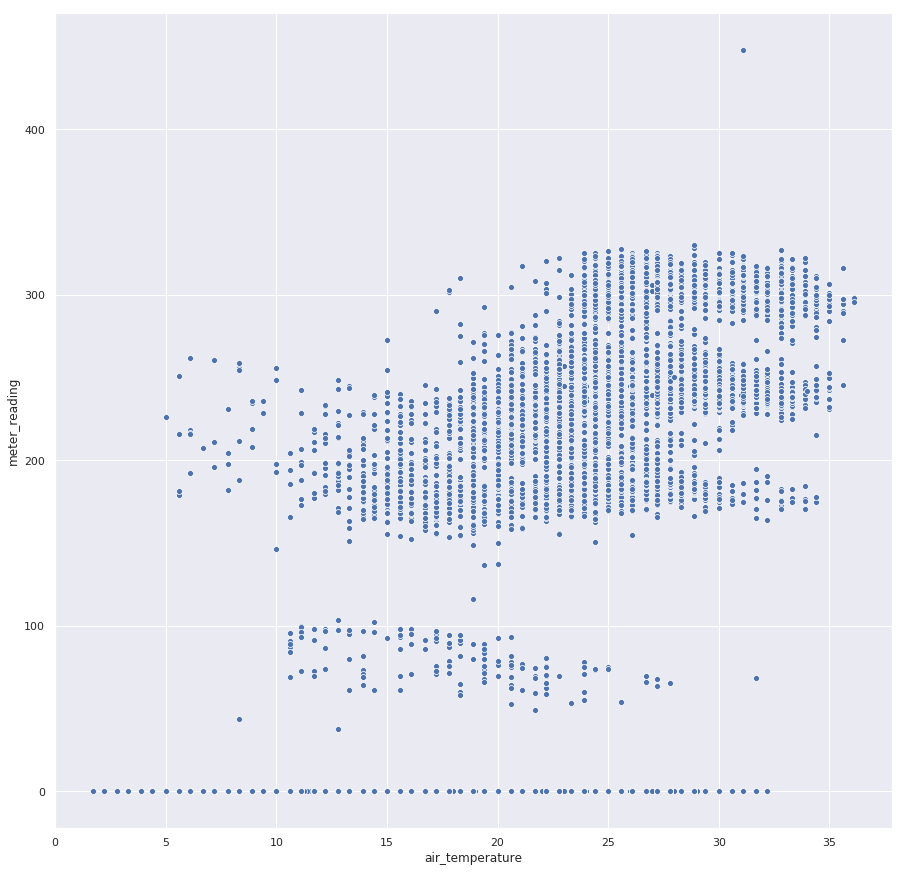

In [25]:
plt.figure(figsize=(15,15))
sns.scatterplot(x='air_temperature', y='meter_reading', data=df)
plt.show()

In [26]:
df['month'] = pd.to_datetime(df['timestamp']).dt.month
df.head()

,building_id,meter,timestamp,meter_reading,t,air_temperature,isMissing,month
0,0,0,2016-01-01 00:00:00,0.0,0,25.0,0,1
1,0,0,2016-01-01 01:00:00,0.0,1,24.4,0,1
2,0,0,2016-01-01 02:00:00,0.0,2,22.8,0,1
3,0,0,2016-01-01 03:00:00,0.0,3,21.1,0,1
4,0,0,2016-01-01 04:00:00,0.0,4,20.0,0,1


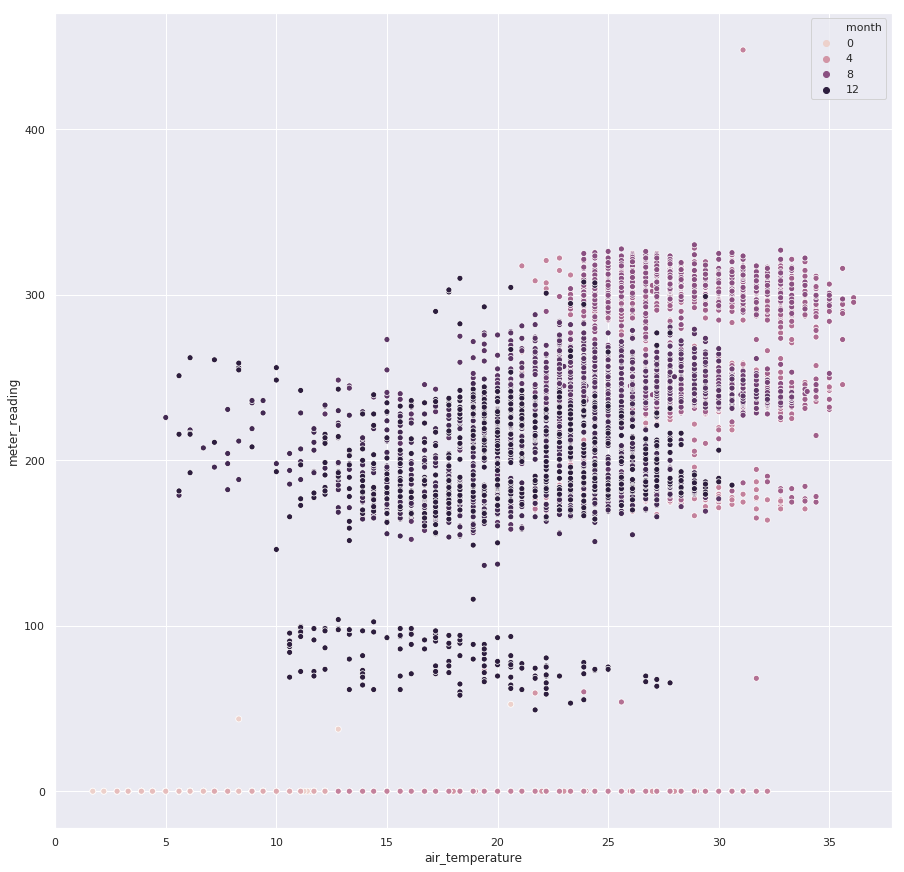

In [27]:
plt.figure(figsize=(15,15))
sns.scatterplot(x='air_temperature', y='meter_reading', data=df, hue='month')
plt.show()

## Matrix Profile

We have data quality issues. We can use the matrix profile to find the regime change. In a production model, we could use this to help select our training data --the most recent data with the least quality issues.

In [28]:
m = 24*7
# this breaks on any other datatype than float64
mp = stumpy.stump(df.meter_reading.values.astype(np.float64), m=m)

In [29]:
help(stumpy.stump)

Help on function stump in module stumpy.stump:

stump(T_A, m, T_B=None, ignore_trivial=True)
    Compute the matrix profile with parallelized STOMP
    
    This is a convenience wrapper around the Numba JIT-compiled parallelized
    `_stump` function which computes the matrix profile according to STOMP.
    
    Parameters
    ----------
    T_A : ndarray
        The time series or sequence for which to compute the matrix profile
    m : int
        Window size
    T_B : ndarray
        The time series or sequence that contain your query subsequences
        of interest. Default is `None` which corresponds to a self-join.
    ignore_trivial : bool
        Set to `True` if this is a self-join. Otherwise, for AB-join, set this
        to `False`. Default is `True`.
    
    Returns
    -------
    out : ndarray
        The first column consists of the matrix profile, the second column
        consists of the matrix profile indices, the third column consists of
        the left matrix pr

In [30]:
mp

array([[18.33030277982336, 42, -1, 42],
       [18.33030277982336, 43, -1, 43],
       [18.33030277982336, 44, -1, 44],
       ...,
       [9.466702227940667, 7174, 7174, -1],
       [9.61193479266948, 7175, 7175, -1],
       [9.906119233530262, 7176, 7176, -1]], dtype=object)

In [31]:
L = 24*7
cac, regime_locations = stumpy.fluss(mp[:, 1], L=L, n_regimes=2, excl_factor=1)

In [32]:
stumpy.fluss(mp[:, 1], L=L, n_regimes=2, excl_factor=1)[0]

array([1., 1., 1., ..., 1., 1., 1.])

In [33]:
regime_locations

array([3212])

# Fluss
Compute the Fast Low-cost Unipotent Semantic Segmentation (FLUSS) for static data.

The idea of regime switching in volatility is rooted in the observation that volatility is usually fairly consistent and "mild", and occasionally very high, say during a market crash. The concept goes further, though. Not only does the volatility level differ markedly in different regimes, but the behavior of volatility does as well (degree of mean reversion, shape of smile, term structure skew, etc). Many models use different regimes to allow the tuning of parameters under different regimes, then switching between regimes, to more accurately model observed behavior.



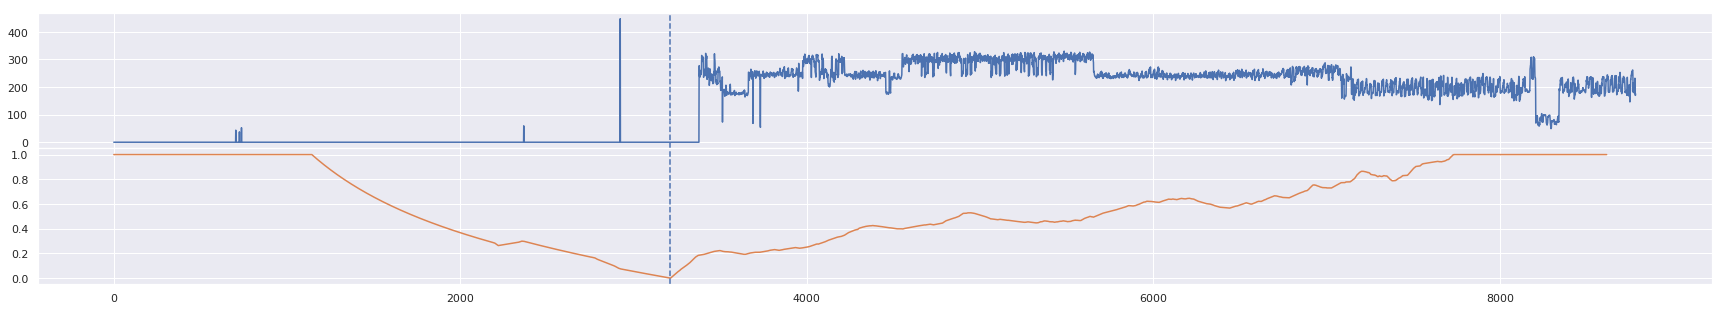

In [34]:
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0}, figsize=(30,5))
axs[0].plot(range(df.meter_reading.shape[0]), df.meter_reading)
axs[0].axvline(x=regime_locations[0], linestyle="dashed")
axs[1].plot(range(cac.shape[0]), cac, color='C1')
axs[1].axvline(x=regime_locations[0], linestyle="dashed")
plt.show()

In [35]:
# In reality (in a streaming "live" data environment) we can't look ahead to see what the future holds...
# How do we detect regime changes in that situation?
# We use a one-directional approach...

In [36]:
stumpy.fluss(mp[:, 1], L=L, n_regimes=2, excl_factor=1)[0]

array([1., 1., 1., ..., 1., 1., 1.])

In [37]:
cac_1d = stumpy._cac(mp[:, 3], L, bidirectional=False, excl_factor=1)

In [38]:
help(stumpy._cac)

Help on function _cac in module stumpy.floss:

_cac(I, L, bidirectional=True, excl_factor=5, custom_iac=None, seed=0)
    Compute the corrected arc curve (CAC)
    
    Parameters
    ----------
    I : ndarray
        The matrix profile indices for the time series of interest
    
    L : int
        The subsequence length that is set roughly to be one period length.
        This is likely to be the same value as the window size, `m`, used
        to compute the matrix profile and matrix profile index but it can
        be different since this is only used to manage edge effects
        and has no bearing on any of the IAC or CAC core calculations.
    
    bidirectional : bool
        Flag for normalizing the arc curve with a bidirectional (`True`) or
        1-dimensional (`False`) idealized arc curve. If a `custom_iac` is
        specified then this flag is ignored.
    
    excl_factor : int
        The multiplying factor for the first and last regime exclusion zones
    
    cust

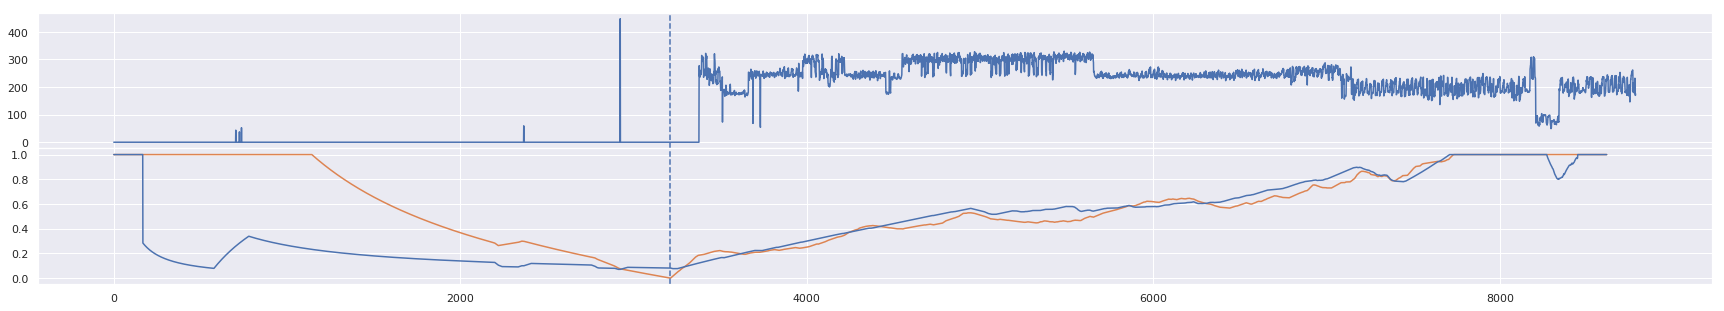

In [39]:
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0}, figsize=(30,5))
axs[0].plot(range(df.meter_reading.shape[0]), df.meter_reading)
axs[0].axvline(x=regime_locations[0], linestyle="dashed")
axs[1].plot(range(cac.shape[0]), cac, color='C1')
axs[1].axvline(x=regime_locations[0], linestyle="dashed")
axs[1].plot(range(cac_1d.shape[0]), cac_1d)
plt.show()

In [40]:
# We see that there appear to be many regime changes early on as we get the meter readings back online.
# There is still a local minimum in the 1-dir corrected arc curve near our previously calculated minimum.
# We just find it a bit later. This is typical behavior.

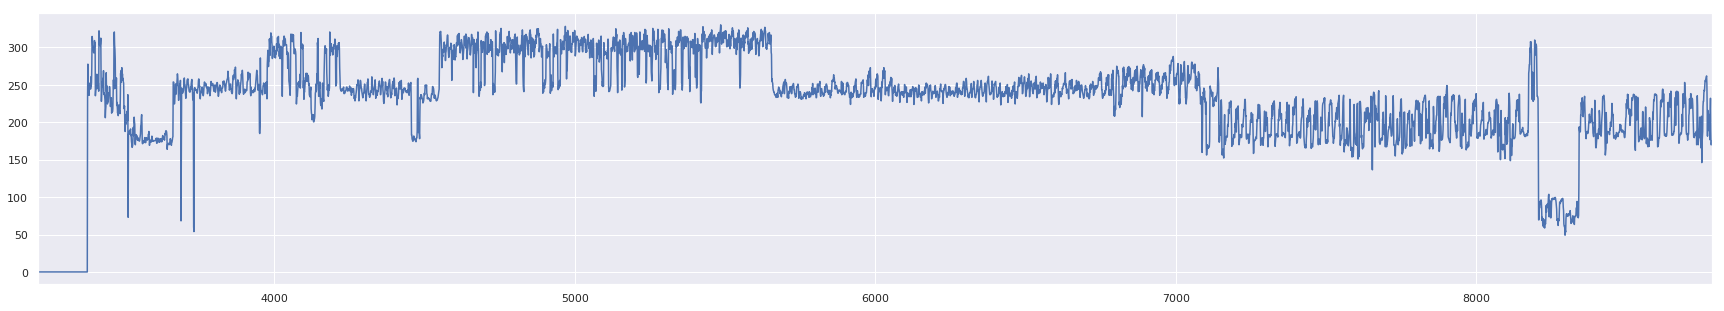

In [41]:
# Let's just take the latter part of the data for further analysis
start = regime_locations[0]
n = N - start
df.meter_reading.tail(n).plot(figsize=(30,5))
plt.show()

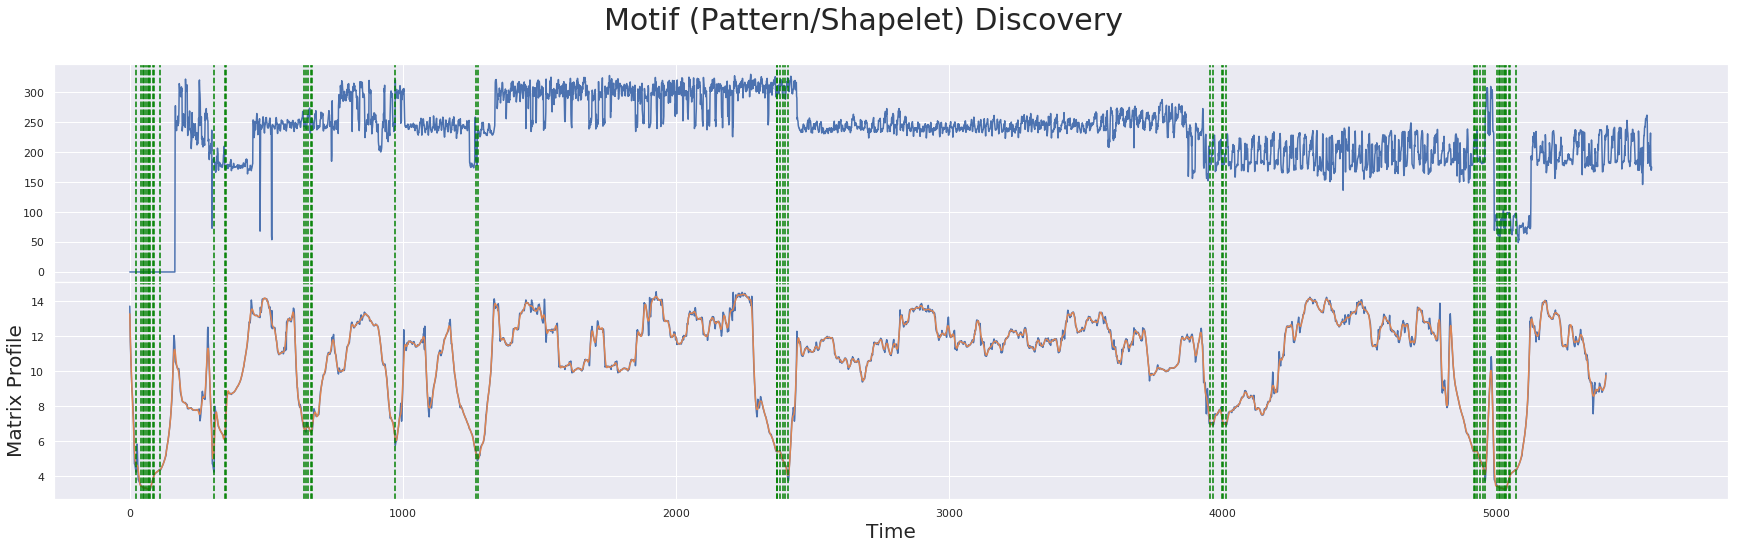

In [42]:
# We can also use the matrix profile for shapelet discovery

df = df.tail(n); gc.collect();
mp = stumpy.stump(df.meter_reading.values.astype(np.float64), m=m)

from scipy.signal import argrelextrema
from scipy.signal import savgol_filter as smooth

# smoothed matrix profile : discriminator
window = 5
discriminator = smooth(mp[:, 0], 4*window+1, 3)
discriminator = smooth(discriminator, 2*window+1, 3)
discriminator = smooth(discriminator, window, 1)

# where do the local minima (shapelets) and maxima (anomalies) occur
t_min = argrelextrema(mp[:, 0], np.less)[0]
t_max = argrelextrema(mp[:, 0], np.greater)[0]

fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0}, figsize=(30,8))
plt.suptitle('Motif (Pattern/Shapelet) Discovery', fontsize='30')

axs[0].plot(df.meter_reading.values)

axs[1].set_xlabel('Time', fontsize ='20')
axs[1].set_ylabel('Matrix Profile', fontsize='20')
axs[1].plot(mp[:, 0])
axs[1].plot(discriminator)

# we'll grab a sample of the shapelets
motifs = []
thresh = discriminator.min() + 4
for t in t_min:
    if discriminator[t] < thresh:
        axs[0].axvline(x=t, linestyle="dashed", c='green')
        axs[1].axvline(x=t, linestyle="dashed", c='green')
        motif = df.loc[(df.t >= t) & (df.t < t+m), 'meter_reading'].values
        if len(motif) == m:
            motifs.append(motif)
plt.show()

In [43]:
# let's make a dataframe
X = pd.DataFrame(motifs)
X.head(3).append(X.tail(3))

,0,1,2,3,4,5,6,7,8,9,...,158,159,160,161,162,163,164,165,166,167
0,242.250,242.250,242.25,239.625,238.875,236.875,241.000,248.500,248.500,252.500,...,260.75,249.875,251.875,236.875,235.500,234.125,243.000,243.000,247.125,218.375
1,249.875,251.125,238.25,242.250,245.750,253.250,251.125,251.125,253.875,231.375,...,210.25,203.375,205.500,208.875,205.500,210.250,200.625,200.625,204.125,204.125
2,286.750,296.250,294.75,286.000,290.750,292.250,291.500,305.000,295.500,295.500,...,217.75,234.750,252.500,232.125,233.375,230.000,228.000,262.750,282.000,297.000
18,306.500,286.000,299.75,305.750,307.250,310.000,308.500,300.250,288.750,286.750,...,315.25,308.500,262.000,260.000,281.250,281.250,296.250,301.750,264.250,293.500
19,310.000,308.500,300.25,288.750,286.750,295.500,303.750,302.250,312.000,300.250,...,281.25,296.250,301.750,264.250,293.500,320.750,303.750,306.500,301.750,297.000
20,291.500,290.750,304.50,310.000,305.750,280.500,284.000,288.000,301.000,306.500,...,295.50,323.500,291.500,252.500,258.000,294.750,316.000,309.250,297.500,299.000


In [44]:
from sklearn.decomposition import PCA

pca = PCA(16, random_state=42)
pca.fit(X)

print(pca.explained_variance_ratio_.sum())

0.9592882976379682


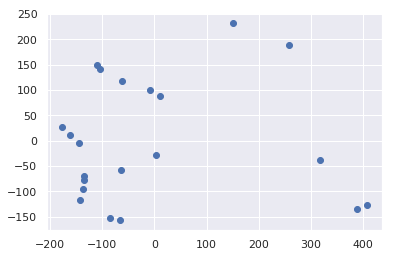

(21, 16)


In [45]:
latent = pca.transform(X)

plt.figure()
plt.scatter(latent[:, 0], latent[:, 1])
plt.show()

print(latent.shape)

KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f3e0a5ba438>,
                 k=None, locate_elbow=True, metric='silhouette', model=None,
                 timings=False)

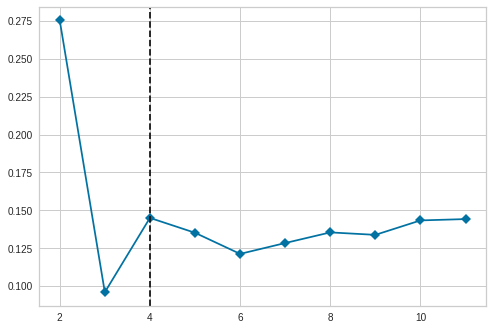

In [46]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

model = KMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=(2,12), 
                              metric='silhouette',
                              timings=False)

visualizer.fit(latent)

21


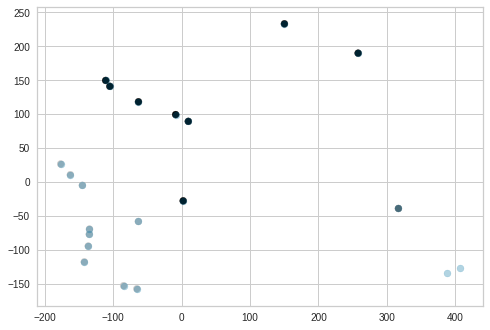

In [47]:
model = KMeans(4, random_state=42)
model.fit(latent)
c = model.predict(latent)

print(len(c))

plt.figure()
plt.scatter(latent[:,0], latent[:,1], c=c)
plt.scatter(latent[:,0], latent[:,1], alpha=0.3)
plt.show()

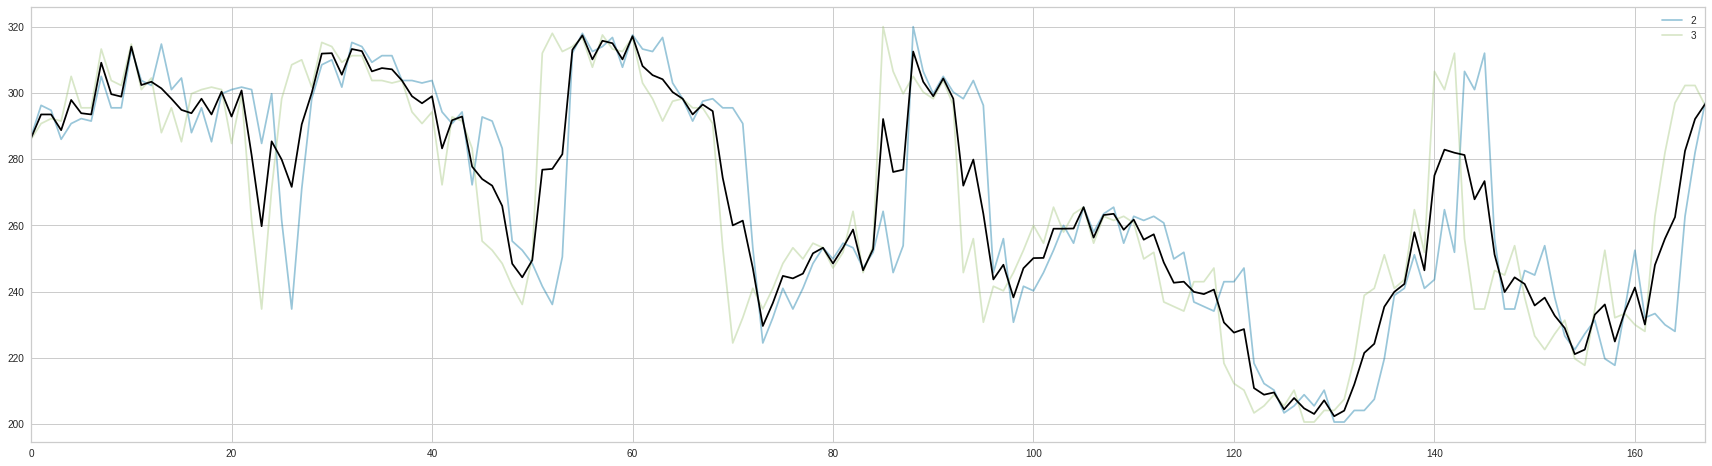

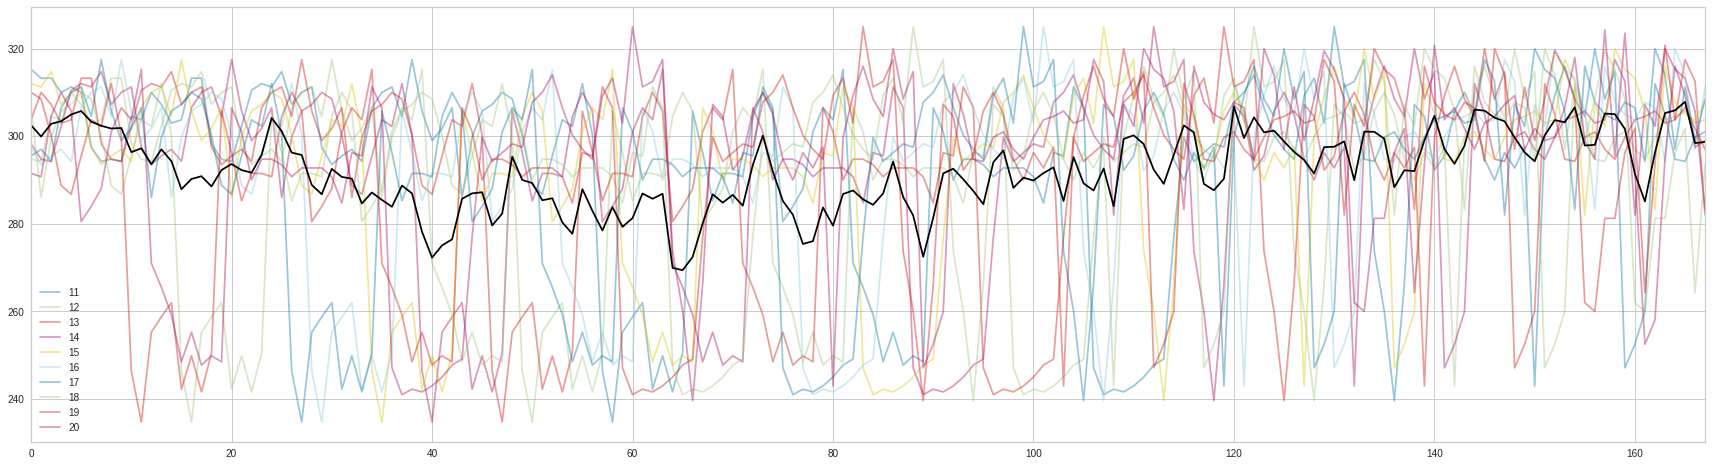

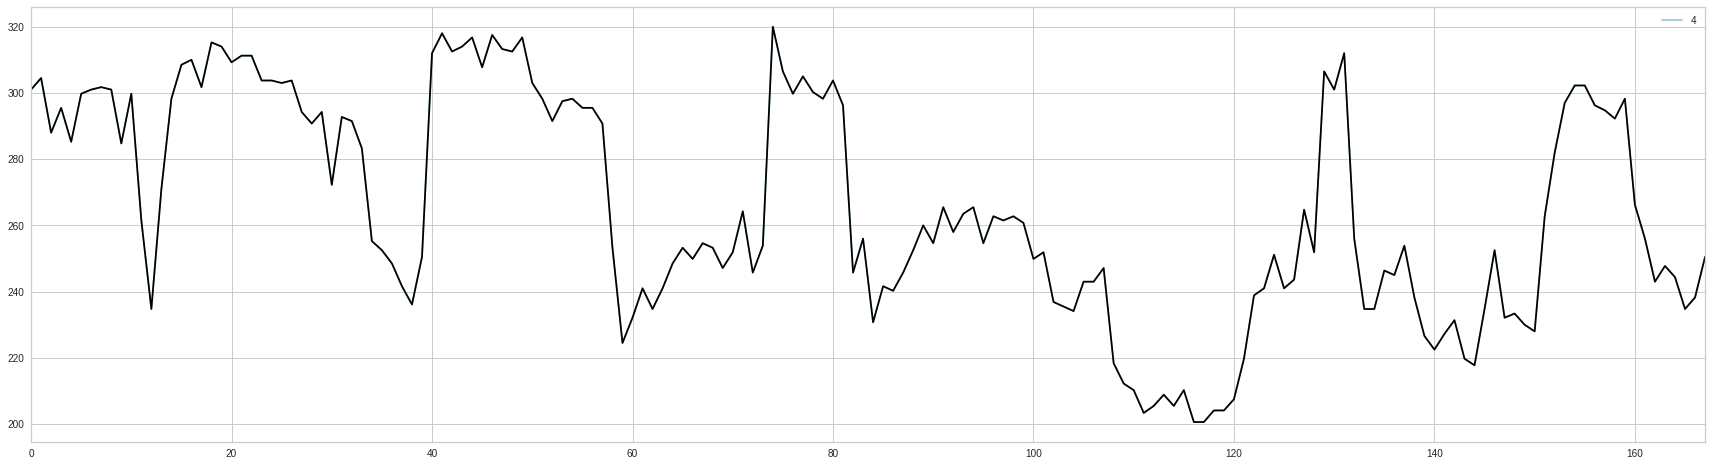

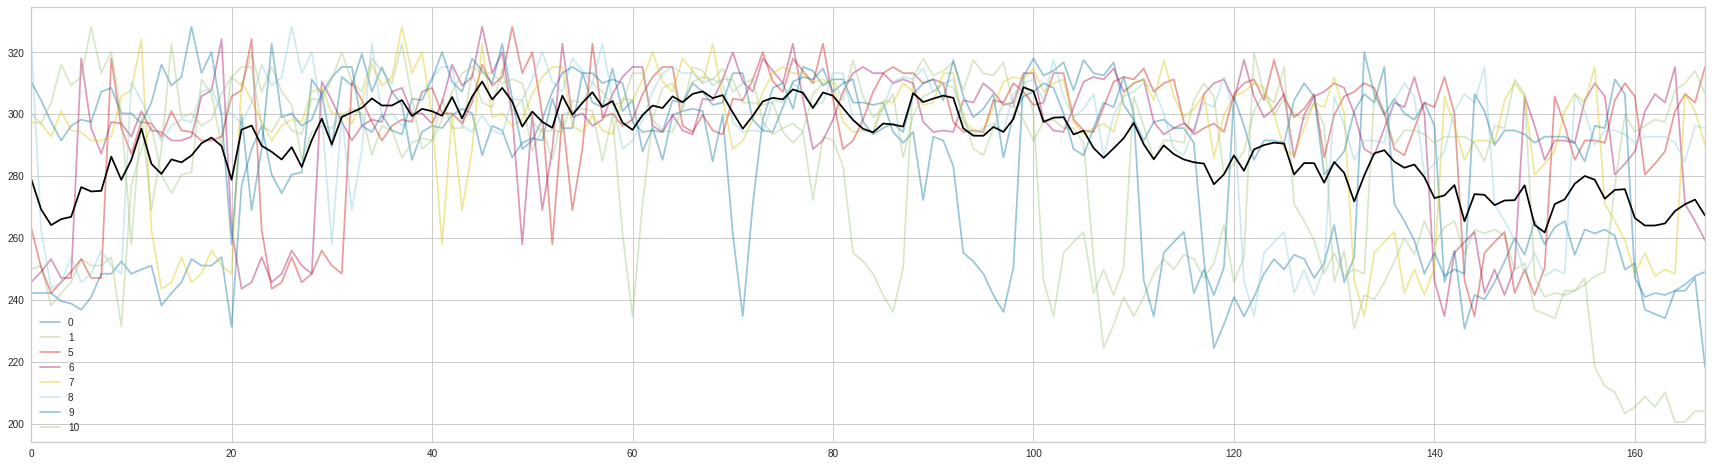

In [48]:
for i in range(4):
    key = (c==i)
    X[key].T.plot(alpha=0.4,figsize=(30,8))
    X[key].T.mean(axis=1).plot(c='Black',figsize=(30,8))
    plt.show()

In [49]:
# some shapelets are in the clusters
# some chains appear to be in the clusters as well

In [50]:
# Now let's try to do some modeling
# We'll start with a simple baseline: 'meter reading' as a function of 'air temperature'
# First, we will use the matrix profiles of both variables (to remove anomalies... eventually --in our second version)

In [51]:
data = df[['t', 'meter_reading', 'air_temperature']]
data /= data.max(); gc.collect();
data.head()

,t,meter_reading,air_temperature
3212,0.365706,0.0,0.878116
3213,0.365820,0.0,0.891967
3214,0.365934,0.0,0.891967
3215,0.366048,0.0,0.847645
3216,0.366162,0.0,0.814404


In [52]:
mp = stumpy.stump(data.air_temperature.values.astype(np.float64), m=m)
n = len(data) - len(mp)
data['air_profile'] = np.append(mp[:,0],[0]*n)

mp = stumpy.stump(data.meter_reading.values.astype(np.float64), m=m)
data['meter_profile'] = np.append(mp[:,0],[0]*n)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


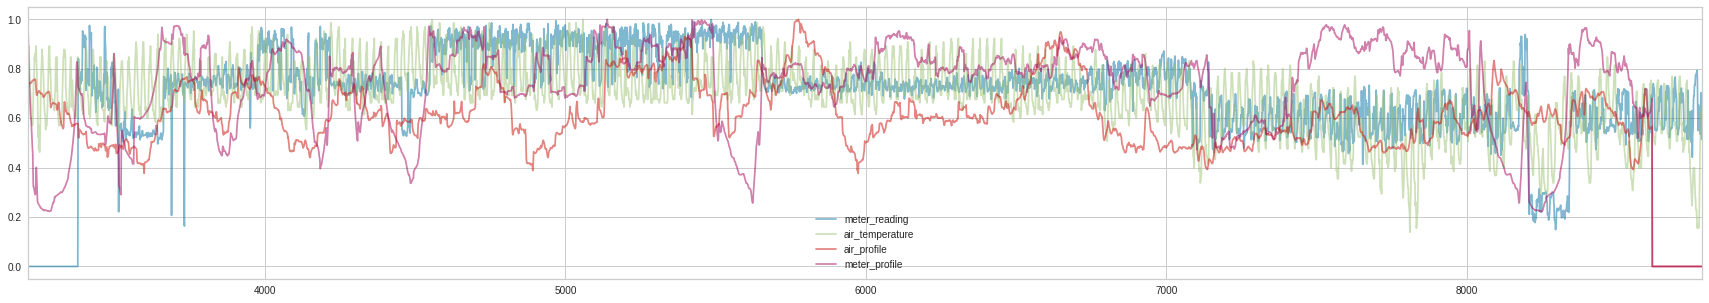

In [53]:
data /= data.max()
cols = [c for c in data.columns.tolist() if c not in ['t']]
data[cols].plot(alpha=0.5, figsize=(30,5))
plt.show()

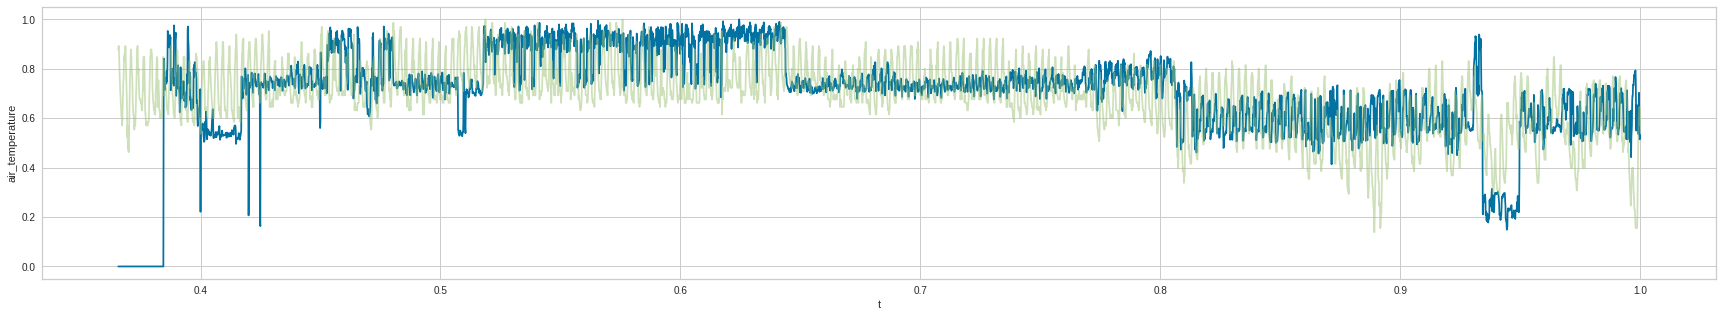

In [54]:
plt.figure(figsize=(30,5))
sns.lineplot(x='t', y='meter_reading', data=data)
sns.lineplot(x='t', y='air_temperature', data=data, alpha=0.5)
plt.show()

In [55]:
# Drop useless info
cols = ['air_temperature', 'meter_reading', 't']
for c in data.columns.tolist():
    if c not in cols:
        del data[c]; gc.collect();
        
data = data.replace(0, np.nan).dropna()
data['meter_reading'] = np.log1p(data['meter_reading'])
y = data['meter_reading']
gc.collect();

window = 11
for c in cols:
    if c not in ['t']:
        X = smooth(data[c], 2*window+1, 3)
        X = smooth(X, window, 1)
        data[c] = X
        del X; gc.collect()

data.head()

,t,meter_reading,air_temperature
3378,0.384607,0.556016,0.756788
3379,0.384720,0.556336,0.752631
3380,0.384834,0.556656,0.748475
3381,0.384948,0.556976,0.744319
3382,0.385062,0.557296,0.740163


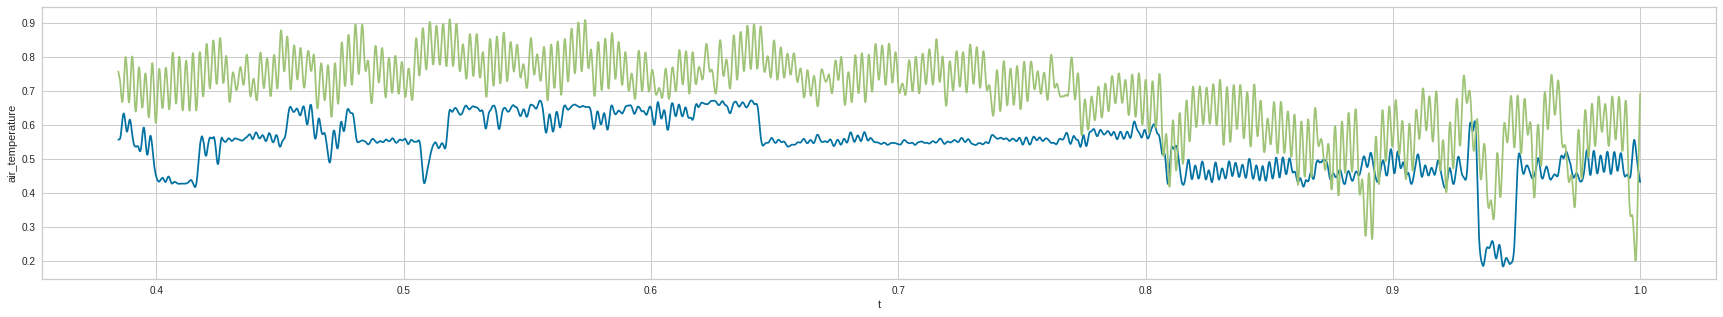

In [56]:
plt.figure(figsize=(30,5))
sns.lineplot(x='t', y='meter_reading', data=data)
sns.lineplot(x='t', y='air_temperature', data=data)
plt.show()

In [57]:
# from pyts.transformation import BOSS
# import category_encoders as ce

In [58]:
from sklearn.linear_model import RANSACRegressor, Ridge, Lasso
from sklearn.model_selection import cross_validate

from seglearn.pipe import Pype
from seglearn.split import temporal_split, TemporalKFold
from seglearn.transform import FeatureRep, SegmentXY, last

N series in train:  1
N series in test:  1
N segments in train:  203
N segments in test:  61
Score:  -0.06423224574445086


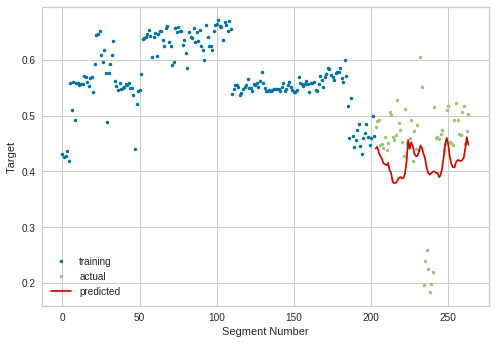

In [59]:
# Note: These need to be list-like objects
X = [data['air_temperature'].values]
y = [data['meter_reading'].values]

X_train, X_test, y_train, y_test = temporal_split(X, y)


# pipe = Pype([('seg', SegmentXY(width=200, overlap=0.9, y_func=last)),
#              ('features', FeatureRep()),
#              ('lin', RANSACRegressor())])

pipe = Pype([('seg', SegmentXY(width=200, overlap=0.9, y_func=last)),
             ('features', FeatureRep()),
             ('lin', Ridge(normalize=True, alpha=.01))])

# pipe = Pype([('seg', SegmentXY(width=200, overlap=0.9, y_func=last)),
#              ('features', FeatureRep()),
#              ('lin', Lasso(normalize=True, alpha=0.0001))])


# fit and score
pipe.fit(X_train, y_train)
score = pipe.score(X_test, y_test)

print("N series in train: ", len(X_train))
print("N series in test: ", len(X_test))
print("N segments in train: ", pipe.N_train)
print("N segments in test: ", pipe.N_test)
print("Score: ", score)

# generate some predictions
ytr, ytr_p = pipe.transform_predict(X_train, y_train)  # training predictions
yte, yte_p = pipe.transform_predict(X_test, y_test)  # test predictions
xtr = np.arange(len(ytr))  # segment number
xte = np.arange(len(yte)) + len(xtr)

# plot the amazing results
plt.plot(xtr, ytr, '.', label="training")
plt.plot(xte, yte, '.', label="actual")
plt.plot(xte, yte_p, label="predicted")
plt.xlabel("Segment Number")
plt.ylabel("Target")
plt.legend()
plt.show()

In [60]:
# now try a cross validation
tkf = TemporalKFold(3)
X, y, cv = tkf.split(X, y)
cv_scores = cross_validate(pipe, X, y, cv=cv, return_train_score=True, return_estimator=True)
print("CV Scores: ", pd.DataFrame(cv_scores))

CV Scores:     fit_time  score_time                                          estimator  \
0  0.011155    0.004457  (SegmentXY(order='F', overlap=0.9, random_stat...   
1  0.009815    0.004466  (SegmentXY(order='F', overlap=0.9, random_stat...   
2  0.009714    0.004206  (SegmentXY(order='F', overlap=0.9, random_stat...   

   test_score  train_score  
0    0.066541     0.588721  
1   -0.444494     0.653133  
2   -0.631674     0.256142  


In [61]:
preds = []
for est in cv_scores['estimator']:
    yte, yte_p =est.transform_predict(X_test, y_test)
    preds.append(yte_p)

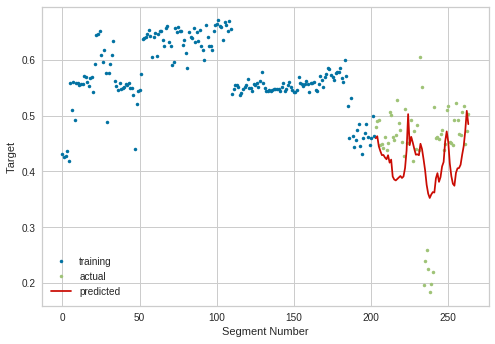

In [62]:
yte_p = np.mean(preds,axis=0)

# plot the amazing results
plt.plot(xtr, ytr, '.', label="training")
plt.plot(xte, yte, '.', label="actual")
plt.plot(xte, yte_p, label="predicted")
plt.xlabel("Segment Number")
plt.ylabel("Target")
plt.legend()
plt.show()

In [63]:
# We can see that this relatively simple baseline is far from perfect.
# There are many features we can engineer to help our model.
# But the most important part is going to be the data preparation and cleaning.

# Next time...
# We will analyze the time series more to see if we can find similarities between different time series.
# Perhaps we can segment the data and build separate models on different clusters of time series.
# This is an easy strategy to improve a public kernel.